# Basic Analysis

## Tweet and user volume

In [66]:
import pandas as pd
import numpy as np
import warnings
import re
import itertools
import collections
from datetime import datetime
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
warnings.filterwarnings('ignore')

In [72]:
df = pd.read_csv ('data/tweets/IchBinHannaUser.csv')
df= df[['author.description', 'author.id', 'author.name', 'author.public_metrics.followers_count', 'author.public_metrics.following_count', 'author.username', 'author_id', 'created_at', 'id', 'lang', 'public_metrics.retweet_count','text', 'hashtags','reference_type','wanted_tag','user.group']]

In [73]:
#only keep tweets from 01/06/2021 - 30/09/2021
df['new_date'] = pd.to_datetime(df['created_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
df_date = df.loc[(df['new_date'] > '2021-06-01 00:00:00') & (df['new_date'] <= '2021-09-30 23:59:59')]

In [76]:
#number of total tweets
print(df.shape[0])
#number of total unique users
print(len(pd.unique(df['author.username'])))

60832
13444


In [75]:
#List the distribution of languages in the tweets (important for preprocessing (stopwords etc.))
print(df_date['lang'].value_counts())

de    52407
en     8425
Name: lang, dtype: int64


As tweets with undefined language mostly consist of only hashtags, URls or emojis, they will be discarded. Otherwise only german and english tweets are kept for the analysis

In [71]:
#This was relevant in an older version of the dataset, before user profiles were added; now the data set contains only german and english tweets to begin with
df_date = df_date.loc[(df_date['lang'] == "de") | (df_date['lang'] == "en")]

In [7]:
pd.set_option('display.max_rows', 100)
#number of remaining tweets
print(df_date.shape[0])
#number of remaining unique users
print(len(pd.unique(df_date['author.id'])))
#overview over "missing values"
print(df_date.count())

60769
4631
author.description                       57827
author.id                                60769
author.name                              60769
author.public_metrics.followers_count    60769
author.public_metrics.following_count    60769
author.username                          60769
author_id                                60769
created_at                               60769
id                                       60769
lang                                     60769
public_metrics.retweet_count             60769
text                                     60769
hashtags                                 60769
reference_type                           60769
wanted_tag                               60769
user.group                               40907
new_date                                 60769
dtype: int64


<AxesSubplot:xlabel='week'>

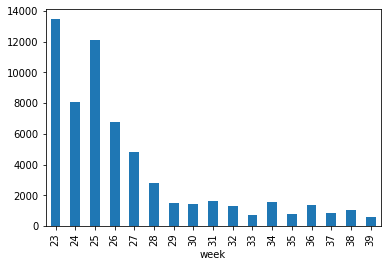

In [8]:
week_groups = df_date.groupby([pd.to_datetime(df_date['new_date']).dt.isocalendar().week]).size()
week_groups.plot(kind='bar', legend = False)

In [9]:
df_june = df_date.loc[(df_date['new_date'] > '2021-06-01 00:00:00') & (df_date['new_date'] <= '2021-06-30 23:59:59')]
df_july = df_date.loc[(df_date['new_date'] > '2021-07-01 00:00:00') & (df_date['new_date'] <= '2021-07-31 23:59:59')]
df_august = df_date.loc[(df_date['new_date'] > '2021-08-01 00:00:00') & (df_date['new_date'] <= '2021-08-31 23:59:59')]
df_september = df_date.loc[(df_date['new_date'] > '2021-09-01 00:00:00') & (df_date['new_date'] <= '2021-09-30 23:59:59')]

<AxesSubplot:xlabel='new_date'>

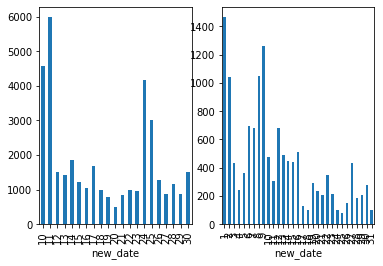

In [10]:
june_groups = df_june.groupby([pd.to_datetime(df_june['new_date']).dt.day]).size()
plt.subplot(1, 2, 1)
june_groups.plot(kind='bar', legend = False)
july_groups = df_july.groupby([pd.to_datetime(df_july['new_date']).dt.day]).size()
plt.subplot(1, 2, 2)
july_groups.plot(kind='bar', legend = False)

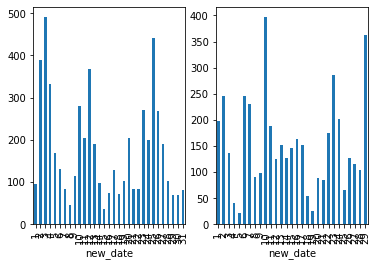

In [11]:
august_groups = df_august.groupby([pd.to_datetime(df_august['new_date']).dt.day]).size()
plt.subplot(1, 2, 1)
august_groups.plot(kind='bar', legend = False)
september_groups = df_september.groupby([pd.to_datetime(df_september['new_date']).dt.day]).size()
plt.subplot(1, 2, 2)
september_groups.plot(kind='bar', legend = False)
plt.xticks(rotation ='vertical')
plt.show()

## Missing Hashtag-Problem

In [12]:
#number of tweets actually containing the hashtag
df_hash = df_date[df_date['text'].str.contains("#ichbinhanna", case = False)]
print(df_hash.shape[0])

60769


In [13]:
#number of tweets not containing the hashtag directly
df_no_hash = df_date[-df_date['text'].str.contains("#ichbinhanna", case = False)]
print(df_no_hash.shape[0])

0


In [14]:
#number of tweets without the hashtag that are retweets (text from original tweet cut off)
print(df_no_hash[df_no_hash['reference_type'] == 'retweeted'].shape[0])
#number of tweets with the hashtag that are retweets
print(df_hash[df_hash['reference_type'] == 'retweeted'].shape[0])

0
40848


In [15]:
test =df_no_hash['text'].loc[df_no_hash['reference_type'] != 'retweeted']
test

Series([], Name: text, dtype: object)

In [16]:
print(df_hash['reference_type'].value_counts())
print(df_no_hash['reference_type'].value_counts())

retweeted       40848
no_reference     8154
quoted           6202
replied_to       5565
Name: reference_type, dtype: int64
Series([], Name: reference_type, dtype: int64)


As a majority of those tweets are retweets that are mostly cut off due to the character constraint, a first approach is to exclude retweets directly for the sentiment analysis, as the original tweet (as long as it falls into our time frame) is most likely in the collection as well. If certain users or networks have to be observed, the whole data set might be of more interest.

In [17]:
#for further investigation
compression_opts = dict(method='zip',
                        archive_name='out.csv')  
df_no_hash.to_csv('out.zip', index=False,
          compression=compression_opts) 

## Get top hashtags appearing in tweets along with #IchBinHanna in september

In [18]:
#make the hashtags a list of strings, then adapt the monthly data frames, also remove tweets not containing the hashtag,
#but keep retweets for this part of the analysis
df_date = df_hash
df_date['hashtags'] = df_hash['hashtags'].str.replace('[', '').str.replace(']','')
df_date['hashtags separated'] = df_date['hashtags'].str.split(',')
df_september = df_date.loc[(df_date['new_date'] > '2021-09-01 00:00:00') & (df_date['new_date'] <= '2021-09-30 23:59:59')]
df_june = df_date.loc[(df_date['new_date'] > '2021-06-01 00:00:00') & (df_date['new_date'] <= '2021-06-30 23:59:59')]
df_july = df_date.loc[(df_date['new_date'] > '2021-07-01 00:00:00') & (df_date['new_date'] <= '2021-07-31 23:59:59')]
df_august = df_date.loc[(df_date['new_date'] > '2021-08-01 00:00:00') & (df_date['new_date'] <= '2021-08-31 23:59:59')]
june_groups = df_june.groupby([pd.to_datetime(df_june['new_date']).dt.day]).size()
july_groups = df_july.groupby([pd.to_datetime(df_july['new_date']).dt.day]).size()
august_groups = df_august.groupby([pd.to_datetime(df_august['new_date']).dt.day]).size()
september_groups = df_september.groupby([pd.to_datetime(df_september['new_date']).dt.day]).size()

In [19]:
print(len(df_september))
print(len(df_june))
print(len(df_july))
print(len(df_august))

4444
37228
13634
5463


In [20]:
#flatten the lists to count occurences of all strings and drop all variations of #IchBinHanna
flat_hashtags = df_september['hashtags separated'].explode().to_frame().dropna()
flat_hashtags = flat_hashtags[-flat_hashtags['hashtags separated'].str.contains("ichbinhanna", case = False)]

In [21]:
#count occurences 
hashtag_count = flat_hashtags.value_counts()
hashtag_count = hashtag_count[hashtag_count > 10].reset_index()

In [22]:
#for further investigation
compression_opts = dict(method='zip',
                        archive_name='top_hashtags.csv')  
hashtag_count.to_csv('out.zip', index=False,
          compression=compression_opts) 

## Identify Events by observing spikes in tweet volume

In [23]:
print("Highest activity in June:\n{}".format(june_groups.sort_values(ascending = False).head(10)))
print("Highest activity in July:\n{}".format(july_groups.sort_values(ascending = False).head(10)))
print("Highest activity in August:\n{}".format(august_groups.sort_values(ascending = False).head(10)))
print("Highest activity in September:\n{}".format(september_groups.sort_values(ascending = False).head(10)))

Highest activity in June:
new_date
11    5989
10    4566
24    4167
25    3016
14    1852
17    1689
30    1514
12    1502
13    1420
26    1271
dtype: int64
Highest activity in July:
new_date
1     1465
9     1257
8     1048
2     1044
6      693
7      682
12     679
16     512
13     486
10     477
dtype: int64
Highest activity in August:
new_date
3     491
25    441
2     390
12    369
4     333
10    280
23    270
26    268
20    204
11    204
dtype: int64
Highest activity in September:
new_date
10    397
29    362
23    285
2     246
6     245
7     231
24    201
1     198
11    189
22    175
dtype: int64


### First approach: search for most frequent words in tweets with the hashtag for the days with the highest activity

Retweets are kept here, as they give an indication about the engagement of a topic and reflect that in a higher word count for frequently discussed themes.

In [24]:
#First step: process the raw text data
#remove linebreaks separately
df_date['processed text'] = df_date['text'].replace(r'\\n',  ' ', regex=True)
#function to remove URLs, punctuation, @ etc. (source: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-frequencies-in-python/)
def rem_url(tweet):
     return " ".join(re.sub("([^0-9A-Za-zßäöü \t])|(\w+:\/\/\S+)", " ", tweet).split())
df_date['processed text'] = df_date['processed text'].apply(rem_url)

In [25]:
#lowercases and tokenize text
df_date['processed text'] = df_date['processed text'].str.lower().str.split()

In [26]:
#remove german and english stopwords (separately for the given language of a tweet)
nltk.download("stopwords")
german_stop = set(stopwords.words('german'))
english_stop = set(stopwords.words('english'))
df_date['processed w/o stopwords'] = df_date[['processed text','lang']].apply(lambda x: ' '.join([word for word in x['processed text'] if word not in (english_stop)]).split() if x['lang'] == 'en' else ' '.join([word for word in x['processed text'] if word not in (german_stop)]).split(),axis=1)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
#remove all words consisting of only one character (isn'"t", it'"s" etc.)
df_date['processed w/o stopwords'] = df_date['processed w/o stopwords'].apply(lambda x: [word for word in x if len(word) > 2])

In [28]:
#most frequent words overall
all_words = list(itertools.chain(*df_date['processed w/o stopwords']))
total_word_count = collections.Counter(all_words)
total_word_count.most_common(25)

[('ichbinhanna', 59192),
 ('innen', 6228),
 ('amreibahr', 5585),
 ('bund', 5280),
 ('bmbf', 5051),
 ('amp', 5046),
 ('wissenschaft', 4577),
 ('wisszeitvg', 4377),
 ('hanna', 4121),
 ('wissenschaftler', 3673),
 ('drkeichhorn', 3396),
 ('viele', 3239),
 ('mehr', 2949),
 ('german', 2848),
 ('mal', 2500),
 ('heute', 2452),
 ('system', 2255),
 ('ichbinhannah', 2244),
 ('geht', 2099),
 ('schon', 1967),
 ('anjakarliczek', 1871),
 ('gibt', 1839),
 ('gerade', 1794),
 ('hannaimbundestag', 1754),
 ('gew', 1715)]

In [29]:
#remove additional stopwords encountered (like "innen" which occurs because of gendering in german), as well as the hashtag itself, rt etc.
add_stop_all = ["rt", "ichbinhanna", "hanna", "amp"]
add_stop_ger = ["mehr", "mal", "innen", "ja", "schon"]
add_stop_en = []
df_date['processed w/o stopwords'] = df_date[['processed w/o stopwords','lang']].apply(lambda x: ' '.join([word for word in x['processed w/o stopwords'] if word not in (add_stop_all) and word not in  (add_stop_en)]).split() if x['lang'] == 'en' else ' '.join([word for word in x['processed w/o stopwords'] if word not in (add_stop_all) and word not in  (add_stop_ger)]).split(),axis=1)

In [30]:
#get most frequent terms for days with highest tweet volume per month
current_day = df_date.loc[(df_date['new_date'] > '2021-06-10 00:00:00') & (df_date['new_date'] <= '2021-06-10 23:59:59')]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("10.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-06-11 00:00:00') & (df_date['new_date'] <= '2021-06-11 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("11.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-06-24 00:00:00') & (df_date['new_date'] <= '2021-06-24 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("24.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-06-25 00:00:00') & (df_date['new_date'] <= '2021-06-25 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("25.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-06-17 00:00:00') & (df_date['new_date'] <= '2021-06-17 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("17.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-06-30 00:00:00') & (df_date['new_date'] <= '2021-06-30 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("30.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-07-01 00:00:00') & (df_date['new_date'] <= '2021-07-01 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("01.07.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-07-02 00:00:00') & (df_date['new_date'] <= '2021-07-02 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("02.07.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-07-09 00:00:00') & (df_date['new_date'] <= '2021-07-09 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("09.07.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-07-08 00:00:00') & (df_date['new_date'] <= '2021-07-08 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("08.07.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-08-03 00:00:00') & (df_date['new_date'] <= '2021-08-03 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("03.08.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-08-04 00:00:00') & (df_date['new_date'] <= '2021-08-04 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("04.08.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-08-25 00:00:00') & (df_date['new_date'] <= '2021-08-25 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("25.08.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-08-12 00:00:00') & (df_date['new_date'] <= '2021-08-12 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("12.08.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-08-26 00:00:00') & (df_date['new_date'] <= '2021-08-26 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("26.08.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-09-29 00:00:00') & (df_date['new_date'] <= '2021-09-29 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("29.09.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-09-10 00:00:00') & (df_date['new_date'] <= '2021-09-10 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("10.09.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-09-02 00:00:00') & (df_date['new_date'] <= '2021-09-02 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("02.09.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-09-06 00:00:00') & (df_date['new_date'] <= '2021-09-06 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("06.09.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-09-03 00:00:00') & (df_date['new_date'] <= '2021-09-03 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("03.09.:\n{}".format(daily_word_count.most_common(25)))

10.06.:
[('wissenschaftler', 939), ('teilen', 786), ('wisszeitvg', 631), ('befristet', 593), ('prekären', 591), ('nachwuchs', 568), ('momentan', 530), ('status', 530), ('angestellte', 529), ('degneranja', 528), ('wissenschaft', 522), ('bmbf', 484), ('german', 341), ('viele', 324), ('innovation', 309), ('gerade', 278), ('deutschland', 267), ('sagt', 254), ('tatsächlich', 254), ('kontext', 250), ('sorgt', 248), ('schwere', 247), ('fördere', 246), ('trending', 245), ('sahiralsaid', 244)]
11.06.:
[('wissenschaftler', 799), ('german', 748), ('wissenschaft', 660), ('system', 613), ('viele', 601), ('teilen', 592), ('trending', 588), ('academic', 557), ('gerade', 438), ('bmbf', 373), ('academia', 335), ('since', 333), ('know', 327), ('befristungen', 317), ('martin', 313), ('wisszeitvg', 308), ('everyone', 308), ('messed', 305), ('hebart', 304), ('pia', 304), ('lamberty', 303), ('bec', 302), ('befristet', 295), ('tweets', 293), ('übrigens', 292)]
24.06.:
[('hannaimbundestag', 1104), ('geht', 41

### Observations June:
10th + 11th: Start of the movement under the hashtag #IchBinHanna
24th: Issue got discussed in the "aktuelle Stunde" of the german Bundestag
25th: Series of tweets of Achim Landwehr, a Dean of studies critizing and portraying the situation of scientific workers
17th: State scecretary Wolf-Dieter Lukas uploads a video addressing the issues that arose with the hashtag
14th: Initial video of the BMBF gets deleted from their website.

### Observations July:
1st +  2nd: Zoom conference of the GEW (union for education and science) 
9th: Journalist Thilo Jung presents the issue at a press conference of the german government 

### Observations August:
3rd + 4th: TV report about #IchBinHanna in ZDF's "heute journal" 

### Observations September:
2nd + 3rd: declaration of new "Berliner Hochschulgesetz"
29th: IchBinHanna discussed in the "hessischer Landtag"

## Distribution of user profiles

In [61]:
df_no_bots = df_date.loc[(df_date['user.group']!='Bot')& (df_date['user.group']!='Academic unspecified')]
df_june_no_bots = df_june.loc[(df_june['user.group']!='Bot')& (df_june['user.group']!='Academic unspecified')]
df_july_no_bots = df_july.loc[(df_july['user.group']!='Bot')& (df_july['user.group']!='Academic unspecified')]
df_august_no_bots = df_august.loc[(df_august['user.group']!='Bot')& (df_august['user.group']!='Academic unspecified')]
df_september_no_bots = df_september.loc[(df_september['user.group']!='Bot')& (df_september['user.group']!='Academic unspecified')]
df_date['user.group'].value_counts().sum()

40907

In [80]:
unique_users = pd.unique(df_date['author.username'])
len(unique_users)

13444

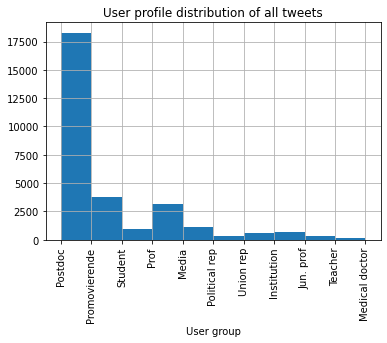

In [51]:
#whole data set
df_no_bots['user.group'].hist()
plt.title('User profile distribution of all tweets')
plt.xlabel('User group')
plt.xticks(rotation='vertical')
plt.show()

To get a broader picture and see if the participants of the discussion changed over time, the distribution is also shown for the single months

In [56]:
df_june['user.group'].value_counts()

Postdoc                 9926
Academic unspecified    5919
Promovierende           2290
Prof                    2000
Media                    728
Bot                      694
Student                  636
Institution              334
Political rep            264
Union rep                248
Jun. prof                221
Teacher                  105
Medical doctor             5
Name: user.group, dtype: int64

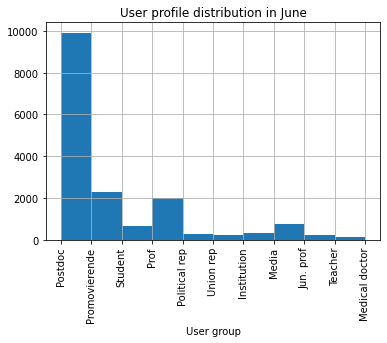

In [52]:
#distribution in June
df_june_no_bots['user.group'].hist()
plt.title('User profile distribution in June')
plt.xlabel('User group')
plt.xticks(rotation='vertical')
plt.show()

In [57]:
df_july['user.group'].value_counts()

Postdoc                 4532
Academic unspecified    2598
Promovierende            861
Prof                     761
Bot                      467
Media                    239
Institution              205
Student                  189
Union rep                124
Jun. prof                 59
Political rep             57
Teacher                   30
Name: user.group, dtype: int64

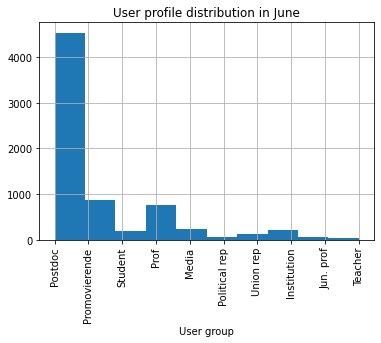

In [53]:
#distribution in July
df_july_no_bots['user.group'].hist()
plt.title('User profile distribution in June')
plt.xlabel('User group')
plt.xticks(rotation='vertical')
plt.show()

In [59]:
df_august['user.group'].value_counts()

Postdoc                 2092
Academic unspecified     903
Promovierende            340
Prof                     225
Bot                      200
Media                     90
Union rep                 74
Student                   65
Institution               57
Political rep             28
Jun. prof                 27
Teacher                    7
Name: user.group, dtype: int64

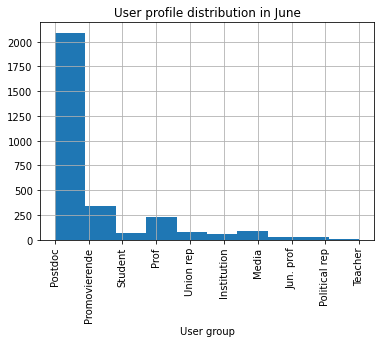

In [54]:
#distribution in August
df_august_no_bots['user.group'].hist()
plt.title('User profile distribution in June')
plt.xlabel('User group')
plt.xticks(rotation='vertical')
plt.show()

In [58]:
df_september['user.group'].value_counts()

Postdoc                 1740
Academic unspecified     752
Promovierende            256
Prof                     131
Union rep                110
Institution               93
Media                     73
Bot                       69
Student                   50
Political rep             19
Jun. prof                 13
Teacher                    1
Name: user.group, dtype: int64

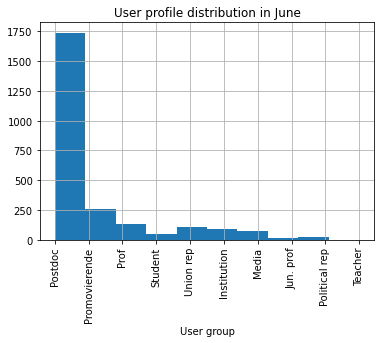

In [55]:
#distribution in August
df_september_no_bots['user.group'].hist()
plt.title('User profile distribution in June')
plt.xlabel('User group')
plt.xticks(rotation='vertical')
plt.show()